# pyGMs Introduction: Learning from Data

In [1]:
import numpy as np
import pyGMs as gm
import matplotlib.pyplot as plt

## Data Representations

PyGMs assumes discrete random variables whose values are in the range {0..d-1}, e.g.:

In [2]:
X = [gm.Var(0,3), gm.Var(1,3), gm.Var(2,2), gm.Var(3,3)]

PyGMs assumes discrete random variables whose values are in the range {0..d-1}.

To represent single observations, we may use any of several useful structures.  The most common of these is a tuple of integers, e.g.,

In [3]:
xe = (0,2,0,1)   # X0=0, X1=2, X2=0, X3=1

Another, also useful representation is to use a dict that maps variables (or their integer labels) to values.  This is particularly useful when we want to represent a partial observation, i.e., when some of the variables are observed but not others:

In [4]:
xe = {0:2, 3:1}  # X0=2, X3=1, other Xi are unobserved

Following standard convention, if we want to represent a partial observation in tuple form, we use the "not-a-number" float value:

In [5]:
xe = (2,np.nan,np.nan,1)  # X0=2, X3=1; X1, X2 are unobserved

Some functions are not equipped to operate with missing values, in which case passing `nan` will usually cause an error.

Occasionally, it is useful to represent partial observations using tuple pairs, which specify the variables that are assigned and their values, respectively:

In [6]:
Xe = (X[0],X[3]);      # Xe = (0,3) (so, just the labels) also usually works
xe = (2,1);            # (Xe,xe) represents X0=2, X3=1, other Xi unobserved

For multiple measurements (e.g., a data set), we can use a list of either the tuple or dict representations, so:

In [7]:
D_dict = [ {0:2, 3:1}, {0:0, 1:3, 2:0, 3:1} ]    # data set of two points, one partial

In [8]:
D_tuple = [ (2,np.nan,np.nan,1), (0,3,0,1) ]      # same data in tuple format

There are some helper functions for converting from one data set representation to another, or print them out nicely:

In [12]:
print(f'Data in dict format:\n {D_tuple}\n    => {gm.t2d(D_tuple)}\n\n')
print(f'Data in tuple format:\n {D_dict}\n    => {gm.d2t(D_dict)}\n\n')
print(f'Data in string format: {[gm.d2s(x) for x in D_dict]}')

Data in dict format:
 [(2, nan, nan, 1), (0, 3, 0, 1)]
    => [{0: 2, 3: 1}, {0: 0, 1: 3, 2: 0, 3: 1}]


Data in tuple format:
 [{0: 2, 3: 1}, {0: 0, 1: 3, 2: 0, 3: 1}]
    => [(2, nan, nan, 1), (0, 3, 0, 1)]


Data in string format: ['2--1', '0301']


It is sometimes useful to represent the data as a numpy array, which allows some additional convenient operations:

In [13]:
D = np.array([ (2,np.nan,np.nan,1), (0,3,0,1) ])
print(D,'\n')
print(f'Data set has {np.isnan(D).sum(0)} missing data in each column.')

[[ 2. nan nan  1.]
 [ 0.  3.  0.  1.]] 

Data set has [0 1 1 0] missing data in each column.


However, numpy arrays should be used with care when interacting with factors, since they (like numpy arrays) have different behavior when indexed by a tuple than when indexed by a list:

In [14]:
f = gm.Factor([X[0],X[1]], [[1,2,3],[4,5,6],[7,8,9]])
print(f'Indexing with a tuple: f[(1,2)]={f[(1,2)]} gives the value at X0=1,X1=2')
print(f'Indexing with a list: f[[1,2]]={f[[1,2]]} instead gives two subarrays of f')    

Indexing with a tuple: f[(1,2)]=6.0 gives the value at X0=1,X1=2
Indexing with a list: f[[1,2]]=[[4. 5. 6.]
 [7. 8. 9.]] instead gives two subarrays of f


## Assessing Model Fit

One of the most basic things we might like to do is evaluate whether our model "fits" a set of observed data.  Typically, we score this using the likelihood of the data under the model.  Let us use the Alarm Bayesian network to illustrate computing the data likelihood:

In [15]:
B = gm.Var(0,2)   # Was there a burglary at Sherlock Holmes' house?
E = gm.Var(1,2)   # Was there an earthquake?
A = gm.Var(2,2)   # Has the alarm gone off?
W = gm.Var(3,2)   # Has Watson called to complain?
H = gm.Var(4,2)   # Has Mrs Hudson called to complain?

X = [B,E,A,W,H]   # we'll often refer to variables as Xi or X[i]

names = dict( (eval(n).label,n) for n in ['B','E','A','W','H'])

p_E = gm.Factor([E], [.998, .002]) # probability of earthquake (false,true)
p_B = gm.Factor([B], [.999, .001]) # probability of burglary
p_A_BE = gm.Factor([A,B,E], 0.0)   # alarm given B,E
# Set  B,E,A                       # 
p_A_BE[0,0,:] = [.999, .001]       # 
p_A_BE[0,1,:] = [.710, .290]       
p_A_BE[1,0,:] = [.060, .940]       # For each setting (b,e), the table should sum to one over A
p_A_BE[1,1,:] = [.050, .950]       #   so that it corresponds to a conditional probability

p_W_A = gm.Factor([A,W], 0.0)      # Probability that Watson calls given the alarm's status
p_W_A[0,:]    = [.95, .05]
p_W_A[1,:]    = [.10, .90]

p_H_A = gm.Factor([A,H], 0.0)      # Probability that Mrs Hudson calls given the alarm's status
p_H_A[0,:]    = [.99, .01]
p_H_A[1,:]    = [.30, .70]

factors = [p_W_A, p_H_A, p_A_BE, p_E, p_B]  # collect all the factors that define the model

model = gm.GraphModel([p_E,p_B,p_A_BE,p_W_A,p_H_A])

### Data Likelihood

Suppose that we observe some data, $D$:

In [16]:
D = [(0, 0, 0, 1, 1), (1, 1, 0, 1, 0), (1, 1, 0, 1, 1), (1, 0, 0, 1, 0), (0, 1, 1, 1, 1), 
     (0, 1, 1, 1, 0), (0, 1, 0, 1, 1), (0, 0, 1, 1, 1), (1, 0, 1, 1, 0), (1, 0, 0, 1, 1)]

How likely is this data under our model?  Since our model is normalized, we can compute the log likelihood of each point, $\log p(x)$, by just evaluating the model at $x$:

In [17]:
LL = [model.logValue(x) for x in D]
print(LL)
print()
print(f'Average log-likeliood of D: {np.mean(LL)}')

[array([-7.60490546]), array([-19.12387826]), array([-23.71899811]), array([-12.72895061]), array([-7.91551841]), array([-8.76281627]), array([-14.15900137]), array([-7.37279324]), array([-8.28096601]), array([-17.32407046])]

Average log-likeliood of D: -12.699189820279875


But what if our model is not normalized?  In that case, we need both $\log f(x)$, the evaluation of our model at $x$, and also the normalizing constant (or partition function), $Z$:

In [18]:
model_W = model.copy()
model_W.condition({W:1})  # model given that we know Watson called

elim = model_W.copy()
elim.eliminate(X, 'sum')
lnZ = elim.logValue([])

LL = [model_W.logValue(x) - lnZ for x in D]
print(LL)
print()
print(f'Average log-likeliood of D given W=1: {np.mean(LL)}')

[array([-4.65106295]), array([-16.17003574]), array([-20.76515559]), array([-9.77510809]), array([-4.9616759]), array([-5.80897376]), array([-11.20515885]), array([-4.41895073]), array([-5.32712349]), array([-14.37022794])]

Average log-likeliood of D given W=1: -9.745347304424087


The helper function `loglikelihood` can perform this calculation for you, either calculating log Z, or using a known value if optionally passed:

In [19]:
LL = gm.loglikelihood(model_W,D)   # pass "logZ=lnZ" if lnZ is already calculated
print(LL)

[[ -4.65106295]
 [-16.17003574]
 [-20.76515559]
 [ -9.77510809]
 [ -4.9616759 ]
 [ -5.80897376]
 [-11.20515885]
 [ -4.41895073]
 [ -5.32712349]
 [-14.37022794]]


### Pseudo-likelihood

Unfortunately, a major complication of using log-likelihood for scoring models is the requirement of calculating the log partition function, which can be computationally difficult.  The computationally simpler "pseudo-likelihood" is sometimes used in its place:

In [20]:
PLL = gm.pseudologlikelihood(model_W,np.array(D))
print(PLL)

[ -5.4225763  -20.61720497 -30.64518144 -14.19056285  -1.36277531
  -2.57890251 -17.40618398  -2.06181856  -1.94167805 -24.21651688]


While not the same as likelihood, the pseudolikelihood can be used to assess relative fit or guide a learning process.  We can see that in our example samples, the log-likelihood and pseudo-loglikelihood are correlated, with data points exhibiting either relatively lower values or higher values for both:

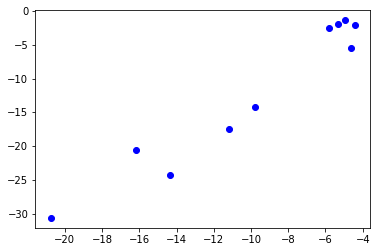

In [21]:
plt.plot(LL,PLL,'b.',ms=12);

## Fitting a Model to Data

We can divide the problem of learning a model from data into two cases: first, where the model and its structure are unknown, and second, the (easier) case in which the model's structure is known, and we only need to learn its parameter values (e.g., the conditional probabilities of a Bayesian network).

**Note:** In general, pyGMs uses `fit_x` to indicate functions that operate directly from the data to select the model in full, i.e., structure and parameter learning.  We use `refit_x` to indicate functions that take an existing model structure and update its parameters (probabilities, etc.) to fit the data set, i.e., parameter learning only.

Let's consider the simpler case first.  If we know the model structure, the most common approach is to select the model parameters that maximize the likelihood of our data, i.e., maximum likelihood learning.

### Empirical probabilities

We saw in the case of a Bayesian network that the maximum likelihood solution is simply given by matching the empirical probabilities in the data. If our data are:

In [22]:
D = [(1, 0, 1, 1, 0), (0, 1, 0, 1, 1), (0, 1, 1, 0, 1), (1, 1, 1, 1, 0), (0, 1, 1, 1, 1), 
     (1, 1, 1, 1, 0), (1, 1, 1, 1, 0), (0, 1, 1, 1, 0), (0, 1, 1, 0, 0), (1, 0, 1, 0, 1)]

we can conveniently count the data matching various patterns using a helper function, `empirical()`:

In [23]:
clique_list = [ [X[0]] ]
phat_list = gm.misc.empirical(clique_list, D)
print(f'Empirical returns a list of the empirical estimates: {phat_list}')
print(f'each of which has the empirical counts for configurations of those variables: {phat_list[0].table}')

Empirical returns a list of the empirical estimates: [Factor({0},[0x153f700])]
each of which has the empirical counts for configurations of those variables: [5. 5.]


There is a parameter `normalize` which we can use to divide by the total number of data, e.g., resulting in estimated probabilities `[0.5, 0.5]` instead of counts `[5,5]`.

If we have a list of conditional probabilities to estimate, we can compute the empirical counts for those subsets of variables, and then normalize them in a conditional manner, so that each "row" of the tables corresponding to the child variable sums to one. Specifically, for every possible configuration of the parent variables, we sum over the child variable and normalize using that value:

In [24]:
model_factors = [p_E,p_B,p_A_BE,p_W_A,p_H_A]  # to easily access the cliques we'll need

phat_factors = gm.misc.empirical([f.vars for f in model_factors], D)

# phat_factors is a list of each estimated counts; let's give them names:
ph_E, ph_B, ph_ABE, ph_WA, ph_HA = phat_factors

# Some of our configurations are zero, since we only have 10 data points.
# To avoid dividing by zero, let's add a small value to ensure positivity:
for f in [ph_E,ph_B,ph_ABE,ph_WA,ph_HA]: f+=1e-6  

# Now, normalize each factor as desired:
ph_E = ph_E/ph_E.sum()
ph_B = ph_B/ph_B.sum()
ph_A_BE = ph_ABE/ph_ABE.sum([A])
ph_W_A = ph_WA/ph_WA.sum([W])
ph_H_A = ph_HA/ph_HA.sum([H])

# Now we can create a Bayes net out of these empirical conditional probabilties:
model_estimate = gm.GraphModel([ph_E,ph_B,ph_A_BE,ph_W_A,ph_H_A])

We can see that the resulting parameters do, indeed, increase the log-likelihood of the training data. (In this case, the fact that we have very few training data to fit these parameters may indicate *overfitting*, of course.)

In [25]:
LL_original = gm.loglikelihood(model,D)   # pass "logZ=lnZ" if lnZ is already calculated
print(f'Original parameters average LL: {LL_original.mean()}')

LL_maxll = gm.loglikelihood(model_estimate,D)   
print(f'After setting parameters using maximum likelihood: {LL_maxll.mean()}')

Original parameters average LL: -11.327094860309254
After setting parameters using maximum likelihood: -2.589476718797504


## Structure Learning

When we do not know the structure of the model, we need to search or select over possible structures.  It turns out this is easy to do if we would like to select the **tree** (each node has at most one parent) that results in the maximum likelihood of the data.

### Chow-Liu Trees
We can efficiently find both the tree structure and parameters that maximize the likelihood of our data over all tree-structured graphs using an algorithm known as Chow-Liu:

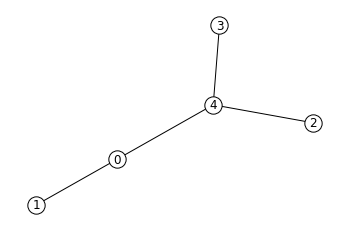

In [26]:
# Note: currently expects data in array or list of tuples form
model_cl = gm.fit_chowliu(np.array(D))

fig,ax=plt.subplots(1,1); ax.set_axis_off();
gm.drawMarkovGraph(model_cl,node_color='w');

We can pick any of these nodes as the root, and orient a Bayes net away from the root to form a tree. 

Since a more complex model can always fit the data better, Chow-Liu will inevitably choose a fully connected tree.
However, `fit_chowliu` can add a BIC complexity penalty that allows it to select a forest, i.e., select fewer edges when they do not improve the log likelihood sufficiently.  Data can also be given weights, for example data from importance sampling, or weighted data during expectation-maximization learning.

#### <span style="color:red"> TODO: possible topics to add? </span>

Fit methods
* Chow Liu
* BN Brute Force
* ILP optimization
* Group-L1-penalized PLL
* Independence tests
* Greedy?

Refit methods
* PLL (sgd; scipy.opt)
* Gradient (estimator?)
  * JT/MC/MCMC/Decomp/Var - work per gradient step?
* IPF
  * Infer method? VE/JT/etc
  * "full fit" vs fixed point update (gradient like?)
